# Image classification using pretrained Resnet-18 and PyTorch

Image classification using STL-10 dataset, which includes 10 classes of images: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck.


# Importing Libraries

In [2]:
%matplotlib inline
import os
import torch
import torchvision
from torch.utils.data import DataLoader, random_split
import numpy as np
from matplotlib import pyplot as plt
import random
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Reading class names
"class_names.txt" file in the dataset folder contains labels of 10 different classes. 

In [3]:
from numpy import loadtxt

class_names = []
class_file = open("./STL10/data/stl10_binary/class_names.txt", "r")
line = class_file.readline()
while (line != ''):  # breaks when EOF is reached
    class_names.append(line.strip())
    line = class_file.readline()

print(class_names)

['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


# Creating Custom Dataset
DataSet class is created to read the images in the train and test folders.

In [4]:
class DataSet(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform, class_names):
        def get_images(class_label, class_name):
            images = [x for x in os.listdir(image_dirs[class_label]) if x.lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.image_dirs = image_dirs
        self.transform = transform
        self.class_names = class_names
        self.class_labels = range(1, len(class_names)+1)
        
        self.images = {}
        for c in self.image_dirs:
            class_name = class_names[c-1]
            self.images[c] = get_images(c, class_name)
        
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_labels])
    
    def __getitem__(self, index):
        class_label = random.choice(self.class_labels)
        index = index % len(self.images[class_label])
        image_name = self.images[class_label][index]
        image_path = os.path.join(self.image_dirs[class_label], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_labels.index(class_label)
    

# Prepare DataLoader
Create a dictionary for the train and test datasets, which include the path of the directories of each class. This will be passed to the DataSet class created above to read the images.

In [5]:
num_classes = len(class_names) # number of classes
train_dirs = {}
train_path = "./STL10/train"
for i, c in enumerate(class_names):
    train_dirs[i+1] = os.path.join(train_path, str(i+1))

print("Train example directories are: \n", train_dirs)

test_dirs = {}
test_path = "./STL10/test"
for i, c in enumerate(class_names):
    test_dirs[i+1] = os.path.join(test_path, str(i+1))

print("="*50)
print("Test example directories are: \n", test_dirs)

Train example directories are: 
 {1: './STL10/train/1', 2: './STL10/train/2', 3: './STL10/train/3', 4: './STL10/train/4', 5: './STL10/train/5', 6: './STL10/train/6', 7: './STL10/train/7', 8: './STL10/train/8', 9: './STL10/train/9', 10: './STL10/train/10'}
Test example directories are: 
 {1: './STL10/test/1', 2: './STL10/test/2', 3: './STL10/test/3', 4: './STL10/test/4', 5: './STL10/test/5', 6: './STL10/test/6', 7: './STL10/test/7', 8: './STL10/test/8', 9: './STL10/test/9', 10: './STL10/test/10'}


# Image Transformations
Image transforms are used to create variations of the training dataset. By intoducing different varoations of the training dataset as well as increasing the number of training images, transforms will prevent overfitting of the model. One should consider that there is no need to apply tranforms to the test dataset, because those are the images that the model's performance is examined with and should represent actual images used in future.

In [6]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(96, 96)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                     std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(96, 96)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                     std=[0.229, 0.224, 0.225])
])

In [9]:
# create the training dataset by instantiating DataSet class using train images
train_dataset = DataSet(train_dirs, train_transform, class_names)

print("="*50)

# create the testing dataset by instantiating DataSet class using test images
test_dataset = DataSet(test_dirs, test_transform, class_names)

Found 500 airplane examples
Found 500 bird examples
Found 500 car examples
Found 500 cat examples
Found 500 deer examples
Found 500 dog examples
Found 500 horse examples
Found 500 monkey examples
Found 500 ship examples
Found 500 truck examples
Found 800 airplane examples
Found 800 bird examples
Found 800 car examples
Found 800 cat examples
Found 800 deer examples
Found 800 dog examples
Found 800 horse examples
Found 800 monkey examples
Found 800 ship examples
Found 800 truck examples


### Let's look at how a random image looks like after the transforms are applied.

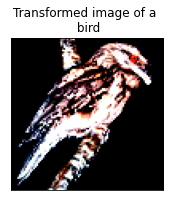

In [11]:
index = 1
image, label = train_dataset[index]
image = image.permute(1,2,0)
image = np.clip(image, 0., 1.)

plt.subplot(1, 2, 1, xticks=[], yticks=[])
plt.imshow(image)
plt.title('Transformed image of a \n {}'.format(class_names[label]));

### DataLoader is used to load the images during the training and evaluation process. 
In each iteration, certain number of images are loaded together, which is called batch size. 
This parameter is equal to 10 here.

In [10]:
batch_size = 10

dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print('Number of created training batches = ', len(dataloader_train))
print('Number of created test batches =', len(dataloader_test))

Number of created training batches =  500
Number of created test batches = 800


# Data Visualization
The following show_images( ) function is created to visualize a batch of images. At the bottom of each image, its true label or class is written. On its left, the label predicted by the model is printed. If the predicted label is the same as the actual label, it is printed in green and otherwise red.

In [9]:
class_names = train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize=(10, 5))
    for i, image in enumerate(images):
        plt.subplot(2, 5, i+1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        
        col = 'green' if preds[i] == labels[i] else 'red'
        
        plt.xlabel(f'True label: {class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'Predicted: {class_names[int(preds[i].numpy())]}', color=col)
    
    plt.tight_layout()
    plt.show()

# Let's check the visualization function
Here I use (preds=labels) just to test the show_images(images, labels, preds) function above.

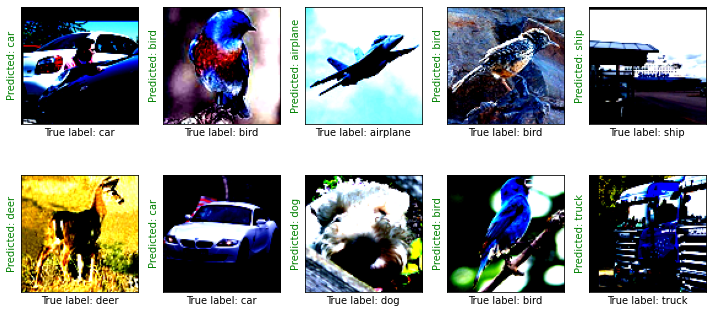

In [10]:
images, labels = next(iter(dataloader_train))
show_images(images, labels, labels)

# Creating the Model
Pretrained Resnet18 is employed here. The last layer of resnet18 is modified here to output predictions for the 10 possible classes of STL10 dataset. CrossEntropyLoss as well as Adam optimizer are used to train the model. Learning rate is set to 5e-5.

In [11]:
resnet18 = torchvision.models.resnet18(pretrained=True)
#print(resnet18)

In [12]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=10)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr = 5e-5)

# Function to show the predicted label of a batch
show_preds( ) is a function that loads a batch of test images, get the model prediction for the images in that batch, and then visualize the batch using show_images( ) function created above.

In [13]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dataloader_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

## Let's check the model prediction before training the model
It is expected to get most predictions wrong and printed in red.

/usr/local/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


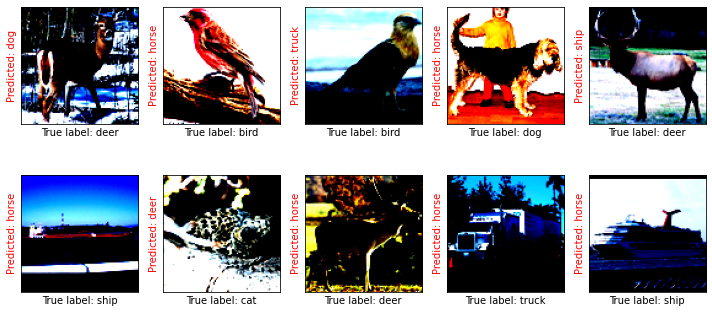

In [14]:
show_preds()

# Train the model
Here the model is trained by looping over the whole training data, during which weights of the neural network is adjusted using the forward and backward propagation. The loop is repeated for a certain number of times which is equal to epochs. Here epochs is set to 20. At the end of each epoch, model performance is evaluated using the test images. Loss and accuracy of the model using train and test sets are recorded. In addition, confusion matrix is computed at the end of the last epoch after final evaluation of the calibrated model. 

In [15]:
train_loss_array = np.array([])
train_accu_array = np.array([])
valid_loss_array = np.array([])
valid_accu_array = np.array([])
confusion_matrix = np.zeros((num_classes, num_classes))
epoch_number_array = np.array([])

epochs = 20

print('Starting training!')
print('='*20)
    
for e in range(0, epochs):
    print('='*20)
    print(f'Training epoch {e+1}/{epochs}')
    print('='*20)
    epoch_number_array = np.append(epoch_number_array, e+1)
    
    train_accu = 0.
    train_loss = 0.     
    resnet18.train()

    for (images, labels) in tqdm(dataloader_train):  
            
        optimizer.zero_grad()
        outputs = resnet18(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_accu += sum((preds == labels).numpy())
            
    train_loss /= len(dataloader_train)
    train_accu /= (len(dataloader_train)*batch_size)
    train_loss_array = np.append(train_loss_array, train_loss)
    train_accu_array = np.append(train_accu_array, train_accu)
    print(f'Train loss: {train_loss:.4f}, Train accuracy: {train_accu:.4f}')

    val_accu = 0.
    val_loss = 0.
    resnet18.eval()

    for (images, labels) in tqdm(dataloader_test):            
        outputs = resnet18(images)
        loss = loss_function(outputs, labels)
        val_loss += loss.item()            
        _, preds = torch.max(outputs, 1)
        val_accu += sum((preds == labels).numpy())
        if (e+1 == epochs):
            for p, t in zip(preds, labels):
                 confusion_matrix[p, t] += 1
                    
    val_loss /= len(dataloader_test)
    val_accu /= (len(dataloader_test)*batch_size)
    valid_loss_array = np.append(valid_loss_array, val_loss)
    valid_accu_array = np.append(valid_accu_array, val_accu)
    print(f'Validation loss: {val_loss:.4f}, Validation accuracy: {val_accu:.4f}')
    

Starting training!
Training epoch 1/20


100%|██████████| 500/500 [04:45<00:00,  1.75it/s]


Train loss: 0.7789, Train accuracy: 0.7500


100%|██████████| 800/800 [02:19<00:00,  5.75it/s]


Validation loss: 0.4314, Validation accuracy: 0.8620
Training epoch 2/20


100%|██████████| 500/500 [04:30<00:00,  1.85it/s]


Train loss: 0.3238, Train accuracy: 0.9006


100%|██████████| 800/800 [02:20<00:00,  5.69it/s]


Validation loss: 0.3813, Validation accuracy: 0.8742
Training epoch 3/20


100%|██████████| 500/500 [04:33<00:00,  1.83it/s]


Train loss: 0.1882, Train accuracy: 0.9474


100%|██████████| 800/800 [02:23<00:00,  5.57it/s]


Validation loss: 0.3746, Validation accuracy: 0.8774
Training epoch 4/20


100%|██████████| 500/500 [04:57<00:00,  1.68it/s]


Train loss: 0.1386, Train accuracy: 0.9574


100%|██████████| 800/800 [02:20<00:00,  5.70it/s]


Validation loss: 0.3692, Validation accuracy: 0.8841
Training epoch 5/20


100%|██████████| 500/500 [04:37<00:00,  1.80it/s]


Train loss: 0.0967, Train accuracy: 0.9738


100%|██████████| 800/800 [02:18<00:00,  5.77it/s]


Validation loss: 0.3966, Validation accuracy: 0.8795
Training epoch 6/20


100%|██████████| 500/500 [04:22<00:00,  1.90it/s]


Train loss: 0.0711, Train accuracy: 0.9808


100%|██████████| 800/800 [02:10<00:00,  6.15it/s]


Validation loss: 0.4117, Validation accuracy: 0.8755
Training epoch 7/20


100%|██████████| 500/500 [04:49<00:00,  1.73it/s]


Train loss: 0.0707, Train accuracy: 0.9790


100%|██████████| 800/800 [02:20<00:00,  5.71it/s]


Validation loss: 0.3785, Validation accuracy: 0.8872
Training epoch 8/20


100%|██████████| 500/500 [04:43<00:00,  1.77it/s]


Train loss: 0.0510, Train accuracy: 0.9874


100%|██████████| 800/800 [02:16<00:00,  5.85it/s]


Validation loss: 0.4107, Validation accuracy: 0.8800
Training epoch 9/20


100%|██████████| 500/500 [04:40<00:00,  1.78it/s]


Train loss: 0.0481, Train accuracy: 0.9878


100%|██████████| 800/800 [02:17<00:00,  5.80it/s]


Validation loss: 0.4267, Validation accuracy: 0.8842
Training epoch 10/20


100%|██████████| 500/500 [04:41<00:00,  1.78it/s]


Train loss: 0.0530, Train accuracy: 0.9836


100%|██████████| 800/800 [02:17<00:00,  5.81it/s]


Validation loss: 0.4520, Validation accuracy: 0.8760
Training epoch 11/20


100%|██████████| 500/500 [04:40<00:00,  1.78it/s]


Train loss: 0.0448, Train accuracy: 0.9868


100%|██████████| 800/800 [02:19<00:00,  5.75it/s]


Validation loss: 0.4808, Validation accuracy: 0.8725
Training epoch 12/20


100%|██████████| 500/500 [04:42<00:00,  1.77it/s]


Train loss: 0.0458, Train accuracy: 0.9876


100%|██████████| 800/800 [02:17<00:00,  5.83it/s]


Validation loss: 0.4690, Validation accuracy: 0.8738
Training epoch 13/20


100%|██████████| 500/500 [04:42<00:00,  1.77it/s]


Train loss: 0.0378, Train accuracy: 0.9890


100%|██████████| 800/800 [02:17<00:00,  5.83it/s]


Validation loss: 0.4350, Validation accuracy: 0.8774
Training epoch 14/20


100%|██████████| 500/500 [04:43<00:00,  1.77it/s]


Train loss: 0.0320, Train accuracy: 0.9912


100%|██████████| 800/800 [02:16<00:00,  5.86it/s]


Validation loss: 0.4519, Validation accuracy: 0.8796
Training epoch 15/20


100%|██████████| 500/500 [04:43<00:00,  1.76it/s]


Train loss: 0.0361, Train accuracy: 0.9898


100%|██████████| 800/800 [02:15<00:00,  5.92it/s]


Validation loss: 0.4659, Validation accuracy: 0.8729
Training epoch 16/20


100%|██████████| 500/500 [04:40<00:00,  1.79it/s]


Train loss: 0.0288, Train accuracy: 0.9908


100%|██████████| 800/800 [02:15<00:00,  5.91it/s]


Validation loss: 0.4739, Validation accuracy: 0.8759
Training epoch 17/20


100%|██████████| 500/500 [04:41<00:00,  1.78it/s]


Train loss: 0.0221, Train accuracy: 0.9934


100%|██████████| 800/800 [02:19<00:00,  5.75it/s]


Validation loss: 0.4913, Validation accuracy: 0.8712
Training epoch 18/20


100%|██████████| 500/500 [04:36<00:00,  1.81it/s]


Train loss: 0.0209, Train accuracy: 0.9940


100%|██████████| 800/800 [02:15<00:00,  5.90it/s]


Validation loss: 0.5016, Validation accuracy: 0.8734
Training epoch 19/20


100%|██████████| 500/500 [04:41<00:00,  1.78it/s]


Train loss: 0.0447, Train accuracy: 0.9872


100%|██████████| 800/800 [02:14<00:00,  5.95it/s]


Validation loss: 0.5181, Validation accuracy: 0.8700
Training epoch 20/20


100%|██████████| 500/500 [04:49<00:00,  1.73it/s]


Train loss: 0.0295, Train accuracy: 0.9910


100%|██████████| 800/800 [02:18<00:00,  5.79it/s]

Validation loss: 0.5145, Validation accuracy: 0.8744


## Let's check the model prediction after training the model
It's expected to get most predictions correct!

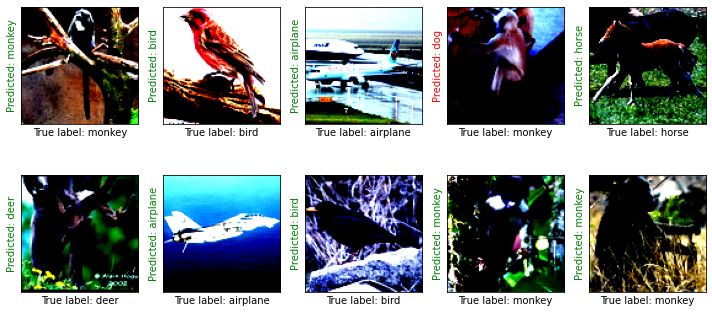

In [19]:
show_preds()

### Confusion matrix of the trained model

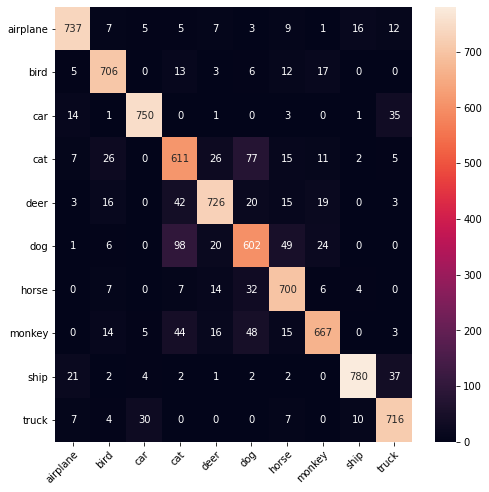

In [17]:
plt.figure(figsize=(8, 8))
ax = plt.gca()
sns.heatmap(confusion_matrix, annot=True, xticklabels=True, yticklabels=True, fmt='g')
ax.set_xticklabels(class_names);
ax.set_yticklabels(class_names);
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
        rotation_mode="anchor");
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",
        rotation_mode="anchor");
plt.show()

### Evolution of accuracy and loss during the training procedure

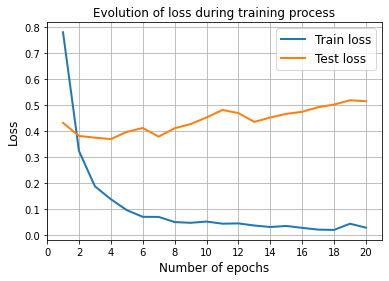

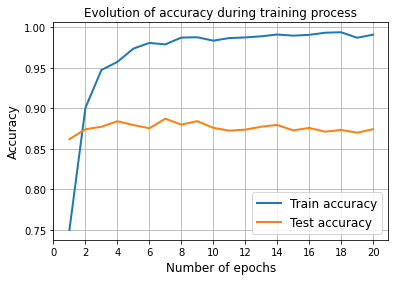

In [18]:
fig, ax = plt.subplots()
plt.xlim([0, epochs+1])
plt.plot(epoch_number_array, train_loss_array, lw=2, label='Train loss')
plt.plot(epoch_number_array, valid_loss_array, lw=2, label='Test loss')
plt.xlabel('Number of epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xticks(np.arange(0, epochs+1, 2))
plt.title('Evolution of loss during training process', fontsize=12)
plt.legend(loc='upper right', fontsize=12)
plt.grid()
plt.show()

fig, ax = plt.subplots()
plt.plot(epoch_number_array, train_accu_array, lw=2, label='Train accuracy')
plt.plot(epoch_number_array, valid_accu_array, lw=2, label='Test accuracy')
plt.xlabel('Number of epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(np.arange(0, epochs+1, 2))
plt.title('Evolution of accuracy during training process', fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.grid()
plt.show() 
